# Imports

In [1]:
import sys
sys.path.append('../')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from ast import literal_eval
from analysis_utils import show_seg, show_seg_composite, extract_fl_loc, extract_fl_loc_table
from plotstyle import save_fig, defaultStyle
from scipy.ndimage import center_of_mass
from matplotlib.gridspec import GridSpec
from matplotlib_scalebar.scalebar import ScaleBar
from brokenaxes import brokenaxes
from skimage.measure import regionprops, label

%matplotlib inline

# Fitting IFN-GFP dose response curve with Hill Function
$$y = \dfrac{x^n}{K^n+x^n}$$
$$\dfrac{1}{y} - 1 = \dfrac{K^n}{x^n}$$
$$\ln\left(\dfrac{1}{y} - 1\right) = n\ln K - n\ln x$$

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


n = 0.70	K = 2.71
Saving figure IFN_GFP_Hill_fitting


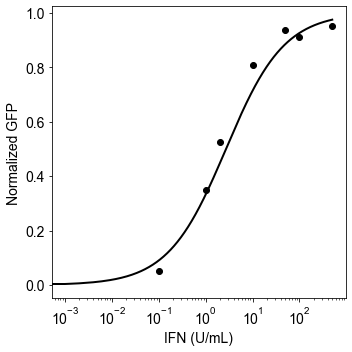

In [2]:
DATA_DIR = os.path.join("../data/")
data_xls = os.path.join(DATA_DIR, "Experimental_Data_1.xlsx")
data = pd.read_excel(data_xls, sheet_name="IFN_GFP_dose_curve", engine="openpyxl")
scaler = MinMaxScaler((0.05, 0.95))
data["GFP"] = scaler.fit_transform(np.nanmean(np.array(data[["GFP_1", "GFP_2", "GFP_3"]]), axis=1, keepdims=True))
data.drop(data[data.IFN==0].index, inplace=True)
p = np.polyfit(np.log(data.IFN), np.log(1/data.GFP - 1), deg=1)
n = - p[0]
K = np.exp(p[1] / n)
print("n = %.2f\tK = %.2f"%(n, K))

defaultStyle()
_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(x="IFN", y="GFP", data=data, color="k")
xdata = np.arange(0, 500, 0.001)
ax.plot(xdata, xdata**n/(K**n+xdata**n), lw=2, color="k")
ax.set_xscale("log")
ax.set_xlabel("IFN (U/mL)")
ax.set_ylabel("Normalized GFP")
np.save("../data/IFN_GFP_Hill.npy", {"n": n, "K": K})
save_fig("IFN_GFP_Hill_fitting")

# Radial diffusion

## Location of sender

In [5]:
ifn_radial_path = "../data/ifn_radial"
img_idx = [0, 1, 2, 4, 5]
imfiles = [os.path.join(ifn_radial_path, "pos%d.tif")%i for i in img_idx]
ims = [skimage.io.imread(f) for f in imfiles]
green_seg_files = [os.path.join(ifn_radial_path, "pos%d.npy"%i) for i in img_idx]

red_ims = [im[:, :, 2] for im in ims]
red_centroid_group = np.zeros((len(img_idx), 2))

for i in [0, 2, 3, 4]:
    normalized_red_im = (red_ims[i] - red_ims[i].min()) / (red_ims[i].max() - red_ims[i].min())
    thresh = normalized_red_im.flatten()[np.argsort(normalized_red_im.flatten())[-100]]
    threshold_im = normalized_red_im > thresh
    com = center_of_mass(threshold_im)
    red_centroid_group[i, 0] = com[0]
    red_centroid_group[i, 1] = com[1]
    
normalized_red_im = (red_ims[1] - red_ims[1].min()) / (red_ims[1].max() - red_ims[1].min())
thresh = normalized_red_im.flatten()[np.argsort(normalized_red_im.flatten())[-500]]
threshold_im = label(normalized_red_im > thresh) == 3
com = center_of_mass(threshold_im)
red_centroid_group[1, 0] = com[0]
red_centroid_group[1, 1] = com[1]
red_centroid_group

OME series: failed to read '2021.4.17_20ng-ml dox_ IFN diffusion_single cell_2x2bin_1_MMStack_Pos1.ome.tif'
OME series: failed to read '2021.4.17_20ng-ml dox_ IFN diffusion_single cell_2x2bin_1_MMStack_Pos1.ome.tif'
OME series: failed to read '2021.4.17_20ng-ml dox_ IFN diffusion_single cell_2x2bin_1_MMStack_Pos1.ome.tif'
OME series: failed to read '2021.4.17_20ng-ml dox_ IFN diffusion_single cell_2x2bin_1_MMStack_Pos2.ome.tif'
OME series: failed to read '2021.4.17_20ng-ml dox_ IFN diffusion_single cell_2x2bin_1_MMStack_Pos2.ome.tif'
OME series: failed to read '2021.4.17_20ng-ml dox_ IFN diffusion_single cell_2x2bin_1_MMStack_Pos2.ome.tif'
OME series: failed to read '2021.4.17_20ng-ml dox_ IFN diffusion_single cell_2x2bin_1_MMStack_Pos3.ome.tif'
OME series: failed to read '2021.4.17_20ng-ml dox_ IFN diffusion_single cell_2x2bin_1_MMStack_Pos3.ome.tif'
OME series: failed to read '2021.4.17_20ng-ml dox_ IFN diffusion_single cell_2x2bin_1_MMStack_Pos3.ome.tif'
OME series: failed to read '

array([[472.14141414, 523.        ],
       [445.125     , 514.125     ],
       [463.43434343, 492.53535354],
       [447.93939394, 545.07070707],
       [542.04040404, 504.15151515]])

## Extract fluorescence and location data

OME series: failed to read '2021.4.17_20ng-ml dox_ IFN diffusion_single cell_2x2bin_1_MMStack_Pos1.ome.tif'
OME series: failed to read '2021.4.17_20ng-ml dox_ IFN diffusion_single cell_2x2bin_1_MMStack_Pos1.ome.tif'
OME series: failed to read '2021.4.17_20ng-ml dox_ IFN diffusion_single cell_2x2bin_1_MMStack_Pos1.ome.tif'
OME series: failed to read '2021.4.17_20ng-ml dox_ IFN diffusion_single cell_2x2bin_1_MMStack_Pos2.ome.tif'
OME series: failed to read '2021.4.17_20ng-ml dox_ IFN diffusion_single cell_2x2bin_1_MMStack_Pos2.ome.tif'
OME series: failed to read '2021.4.17_20ng-ml dox_ IFN diffusion_single cell_2x2bin_1_MMStack_Pos2.ome.tif'
OME series: failed to read '2021.4.17_20ng-ml dox_ IFN diffusion_single cell_2x2bin_1_MMStack_Pos3.ome.tif'
OME series: failed to read '2021.4.17_20ng-ml dox_ IFN diffusion_single cell_2x2bin_1_MMStack_Pos3.ome.tif'
OME series: failed to read '2021.4.17_20ng-ml dox_ IFN diffusion_single cell_2x2bin_1_MMStack_Pos3.ome.tif'
OME series: failed to read '

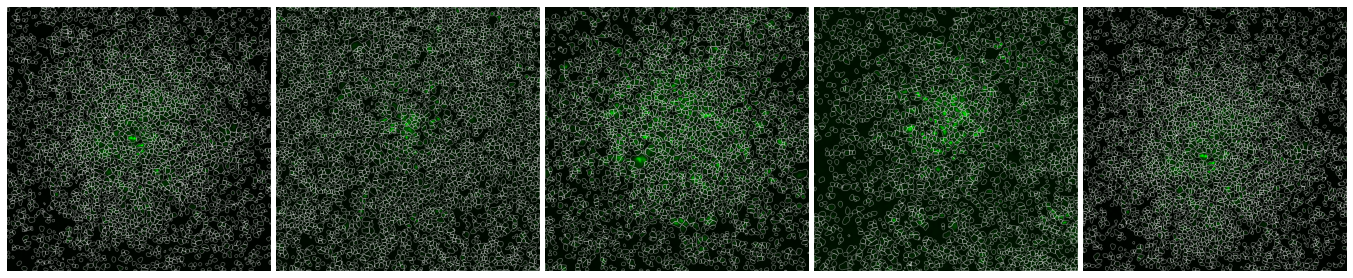

In [6]:
_, ax = plt.subplots(1, 5, figsize=(24, 5))
plt.subplots_adjust(wspace=0.02)
props_group = []
for i in range(len(img_idx)):
    show_seg(green_seg_files[i], imfiles[i], ax=ax[i], chan=1, adjust=1)
    props = extract_fl_loc(green_seg_files[i], imfiles[i], chan=1)
    props_group.append(np.array([[p.mean_intensity, np.sqrt(((np.array(p.centroid) - red_centroid_group[i]) ** 2).sum())] for p in props]))

## Determine the range of fluorescence

In [79]:
percent = 50
all_fluorescences = np.concatenate([props_group[idx][:, 0] for idx in range(len(props_group))])
min_fl = all_fluorescences[np.argsort(all_fluorescences)[percent//50]]
max_fl = all_fluorescences[np.argsort(all_fluorescences)[-percent//50]]

## Main figure

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving figure ifn_radial_main


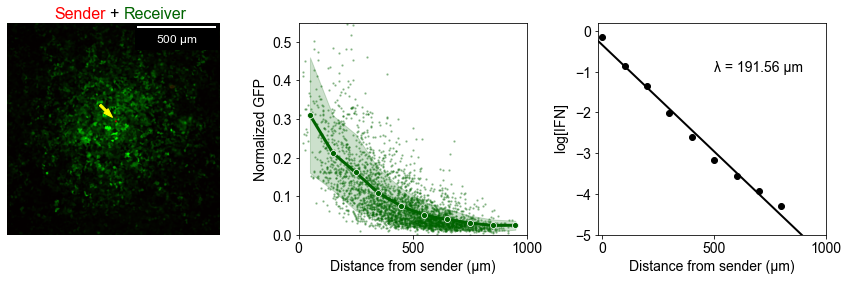

In [95]:
main_fig_index  = [0]
_, ax = plt.subplots(1, 3, figsize=(12, 4))
plt.subplots_adjust(wspace=0.05)
defaultStyle()

for i, idx in enumerate(main_fig_index):
    # ax1 = fig.add_subplot(gs1[i, 0])
    # ax1.imshow(ims[idx][:, :, 0], cmap="gray")
    raw_im = ims[idx]
    rgb_im = np.zeros_like(raw_im, dtype=float)
    rgb_im[:, :, 0] = (raw_im[:, :, 2] - np.min(raw_im[:, :, 2])) / (np.max(raw_im[:, :, 2]) - np.min(raw_im[:, :, 2]))
    rgb_im[:, :, 1] = (raw_im[:, :, 1] - min_fl) / (max_fl - min_fl)
    ax[0].imshow(rgb_im)
    scalebar = ScaleBar(1.3, units="um", color="w", box_color='k', fixed_value=500, font_properties={"size": 12, "family": "Arial"})
    ax[0].add_artist(scalebar)
    arrowlen = 75
    ax[0].arrow(red_centroid_group[idx, 1] - arrowlen, red_centroid_group[idx, 0] - arrowlen, arrowlen * 0.8, arrowlen * 0.8, width=10, color="yellow", length_includes_head=True)
    ax[0].axis("off")    
    ax[0].text(350, -5, "Sender", ha="center", va="bottom", size=16, color="red")
    ax[0].text(512, -5, "+", ha="center", va="bottom", size=16, color="black")
    ax[0].text(712, -5, "Receiver", ha="center", va="bottom", size=16, color="darkgreen")
    
    distances = props_group[idx][:, 1] * 1.3
    fluorescences = props_group[idx][:, 0]
    fluorescences = (fluorescences - min_fl) / (max_fl - min_fl)
    ax[1].scatter(distances, fluorescences, s=2, c="darkgreen", alpha=0.3)
    
    xinterval = 100
    xbin = np.arange(0, 1000, xinterval)
    binned_distances = np.digitize(distances, xbin)
    gradient_data = np.stack([binned_distances, fluorescences], axis=1)
    gradient_df = pd.DataFrame(gradient_data, columns=["binned_distance", "intensity"])
    gradient_df.binned_distance = gradient_df.binned_distance.apply(lambda x: x * xinterval - xinterval / 2) # + xinterval / 2)
    sns.lineplot(x="binned_distance", y="intensity", data=gradient_df, ax=ax[1], ci='sd', color="darkgreen", lw=3, marker="o")
    ax[1].axis([0, 1000, 0, 0.55])
    ax[1].set_xticks([0, 500, 1000])
    ax[1].set_xlabel("Distance from sender (μm)")
    ax[1].set_ylabel("Normalized GFP")
    
    gfp_gradient = np.array([gradient_df[gradient_df.binned_distance == d].intensity.mean() for d in gradient_df.binned_distance.unique()])
    ifn_gradient = np.exp(- np.log(1/gfp_gradient - 1) / n + np.log(K))
    ax[2].scatter(xbin[-2::-1], np.log(ifn_gradient)[1:], color="k")
    p = np.polyfit(xbin[-2::-1], np.log(ifn_gradient)[1:], deg=1)
    xdata = np.arange(-20, 1000, 1)
    ax[2].plot(xdata, xdata * p[0] + p[1], color="k", lw=2)
    ax[2].set_xlim([-20, 870])
    ax[2].set_xlabel("Distance from sender (μm)")
    ax[2].set_ylabel("$\log\mathrm{[IFN]}$")
    ax[2].set_ylim([-5, 0.2])
    ax[2].set_xticks([0, 500, 1000])
    ax[2].text(500, -1, "λ = %.2f μm"%(-1/p[0]), fontsize=14)
    
save_fig("ifn_radial_main")

## Supp

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Characteristic length: 142.18 μm
Characteristic length: 225.46 μm
Characteristic length: 184.39 μm
Characteristic length: 209.12 μm
Saving figure ifn_radial_supp


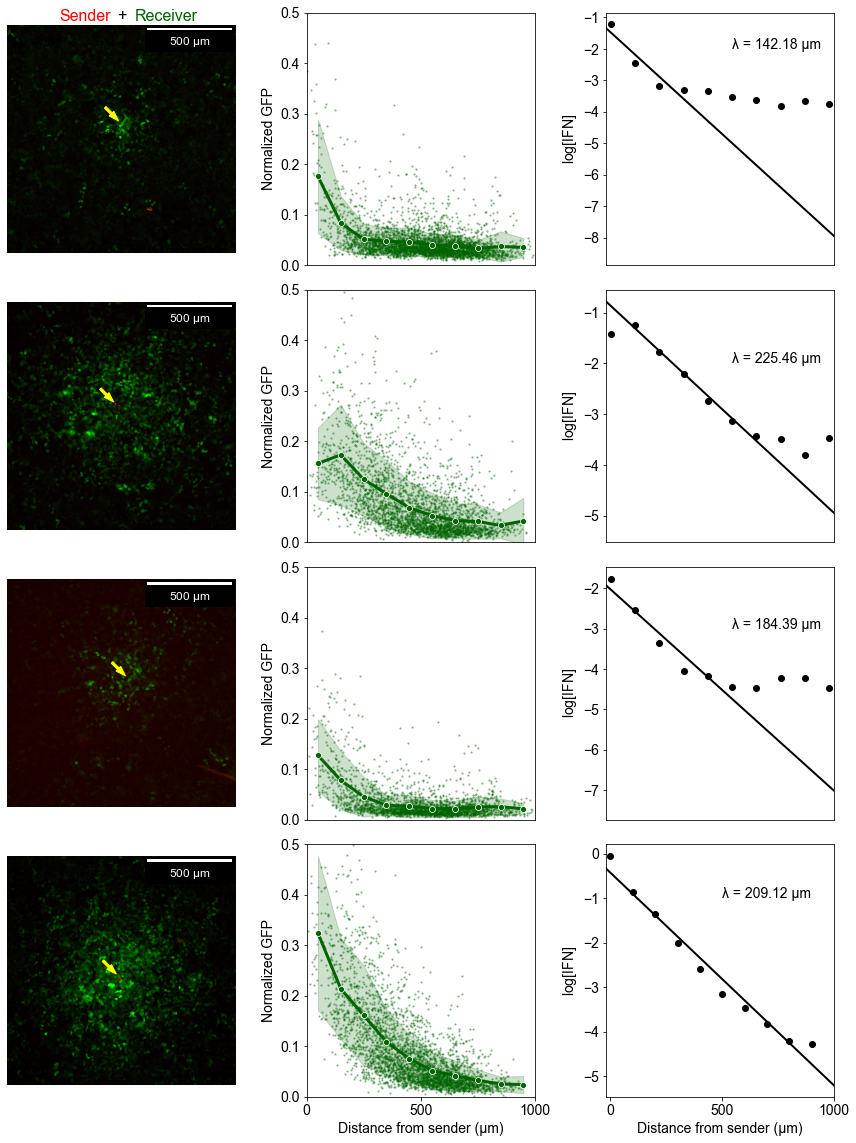

In [94]:
main_fig_index  = [1, 2, 3, 4]
_, ax = plt.subplots(4, 3, figsize=(12, 16))
plt.subplots_adjust(wspace=0.2, hspace=0.02)
defaultStyle()

for i, idx in enumerate(main_fig_index):
    # ax1 = fig.add_subplot(gs1[i, 0])
    # ax1.imshow(ims[idx][:, :, 0], cmap="gray")
    raw_im = ims[idx]
    rgb_im = np.zeros_like(raw_im, dtype=float)
    rgb_im[:, :, 0] = (raw_im[:, :, 2] - np.min(raw_im[:, :, 2])) / (np.max(raw_im[:, :, 2]) - np.min(raw_im[:, :, 2]))
    rgb_im[:, :, 1] = (raw_im[:, :, 1] - min_fl) / (max_fl - min_fl)
    ax[i, 0].imshow(rgb_im)
    scalebar = ScaleBar(1.3, units="um", color="w", box_color='k', fixed_value=500, font_properties={"size": 12, "family": "Arial"})
    ax[i, 0].add_artist(scalebar)
    arrowlen = 75
    ax[i, 0].arrow(red_centroid_group[idx, 1] - arrowlen, red_centroid_group[idx, 0] - arrowlen, arrowlen * 0.8, arrowlen * 0.8, width=10, color="yellow", length_includes_head=True)
    ax[i, 0].axis("off")
    
    distances = props_group[idx][:, 1] * 1.3
    fluorescences = props_group[idx][:, 0]
    fluorescences = fluorescences = (fluorescences - min_fl) / (max_fl - min_fl)
    ax[i, 1].scatter(distances, fluorescences, s=2, c="darkgreen", alpha=0.3)
    
    xinterval = 100
    xbin = np.arange(0, 1000, xinterval)
    binned_distances = np.digitize(distances, xbin)
    gradient_data = np.stack([binned_distances, fluorescences], axis=1)
    gradient_df = pd.DataFrame(gradient_data, columns=["binned_distance", "intensity"])
    gradient_df.binned_distance = gradient_df.binned_distance.apply(lambda x: x * xinterval - xinterval / 2) # + xinterval / 2)
    sns.lineplot(x="binned_distance", y="intensity", data=gradient_df, ax=ax[i, 1], ci='sd', color="darkgreen", lw=3, marker="o")
    ax[i, 1].axis([0, 1000, 0, 0.5])
    ax[i, 1].set_xticks([])
    ax[i, 1].set_ylabel("Normalized GFP")
    ax[i, 1].set_xlabel("")
    
    gfp_gradient = np.array([gradient_df[gradient_df.binned_distance == d].intensity.mean() for d in xbin + xinterval / 2])
    ifn_gradient = np.exp(- np.log(1/gfp_gradient - 1) / n + np.log(K))
    
    xdata = np.arange(-20, 1000, 1)
    ax[i, 2].scatter(xbin, np.log(ifn_gradient), color="k")
    
    if i == 0:
        p = np.polyfit(xbin[:4], np.log(ifn_gradient)[:4], deg=1)        
        ax[i, 2].text(500, -2, "λ = %.2f μm"%(-1/p[0]), fontsize=14)
    elif i == 1:
        p = np.polyfit(xbin[1:-3], np.log(ifn_gradient)[1:-3], deg=1) 
        ax[i, 2].text(500, -2, "λ = %.2f μm"%(-1/p[0]), fontsize=14)
    elif i == 2:
        p = np.polyfit(xbin[:6], np.log(ifn_gradient)[:6], deg=1)
        ax[i, 2].text(500, -3, "λ = %.2f μm"%(-1/p[0]), fontsize=14)
    elif i == 3:
        p = np.polyfit(xbin, np.log(ifn_gradient), deg=1)
        ax[i, 2].text(500, -1, "λ = %.2f μm"%(-1/p[0]), fontsize=14)
    
    ax[i, 2].plot(xdata, xdata * p[0] + p[1], color="k", lw=2)        
    print("Characteristic length: %.2f μm"%(-1/p[0]))
        
    ax[i, 2].set_xlim([-20, 920])
    # ax[i, 2].set_ylim([-5, 0.5])
    ax[i, 2].set_xlabel("")
    ax[i, 2].set_ylabel("$\log\mathrm{[IFN]}$")
    ax[i, 2].set_xticks([])
    
    if i == 0:
        ax[i, 0].text(350, -5, "Sender", ha="center", va="bottom", size=16, color="red")
        ax[i, 0].text(512, -5, "+", ha="center", va="bottom", size=16, color="black")
        ax[i, 0].text(712, -5, "Receiver", ha="center", va="bottom", size=16, color="darkgreen")
    elif i == 3:
        ax[i, 1].set_xticks([0, 500, 1000])
        ax[i, 1].set_xlabel("Distance from sender (μm)")
        ax[i, 2].set_xticks([0, 500, 1000])
        ax[i, 2].set_xlabel("Distance from sender (μm)")        
save_fig("ifn_radial_supp")

$$D = 100 \mu m^2 / s$$

$$k = 100 / 200^2 = 2.5\times 10^{-3} s^{-1}$$


# Linear diffusion

## Show segmentations

In [3]:
ifn_linear_path = "../data/ifn_linear"
intensities = [100, 500, 1100]
durations = [5, 30, 60]
control = "nolight"

idx = 0
props_arr_group = []
raw_im_group = []
group_names = []
for intensity in intensities:
    for duration in durations:
        im_file = os.path.join(ifn_linear_path, "%d_%d.tif"%(duration, intensity))
        if not os.path.exists(im_file):
            continue
        print(im_file)
        group_names.append(im_file)
        seg_file = os.path.join(ifn_linear_path, "%d_%d_green_seg.npy"%(duration, intensity))
        im = skimage.io.imread(im_file)
        masks = np.load(seg_file, allow_pickle=True).item()["masks"]
        props = regionprops(masks, intensity_image=im[1, :, :])
        raw_im_group.append(im)
        props_arr = np.array([[p.mean_intensity, p.centroid[1]] for p in props])
        props_arr_group.append(props_arr)
        idx += 1
        
im_file = os.path.join(ifn_linear_path, "nolight.tif")
print(im_file)
seg_file = os.path.join(ifn_linear_path, "nolight_green_seg.npy")
im = skimage.io.imread(im_file)
raw_im_group.append(im)
masks = np.load(seg_file, allow_pickle=True).item()["masks"]
props = regionprops(masks, intensity_image=im[1, :, :])
props_arr = np.array([[p.mean_intensity, p.centroid[1]] for p in props])
props_arr_group.append(props_arr)

../data/ifn_linear/30_100.tif
../data/ifn_linear/30_500.tif
../data/ifn_linear/5_1100.tif
../data/ifn_linear/30_1100.tif
../data/ifn_linear/60_1100.tif
../data/ifn_linear/nolight.tif


## Normalize GFP

In [31]:
min_percent = 50
max_percent = 100
all_fluorescences = np.concatenate([props_arr[:, 0] for props_arr in props_arr_group])
min_fl = all_fluorescences[np.argsort(all_fluorescences)[len(all_fluorescences)//min_percent]]
max_fl = all_fluorescences[np.argsort(all_fluorescences)[-len(all_fluorescences)//max_percent]]

## Main

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
../plotstyle.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saving figure ifn_linear_main


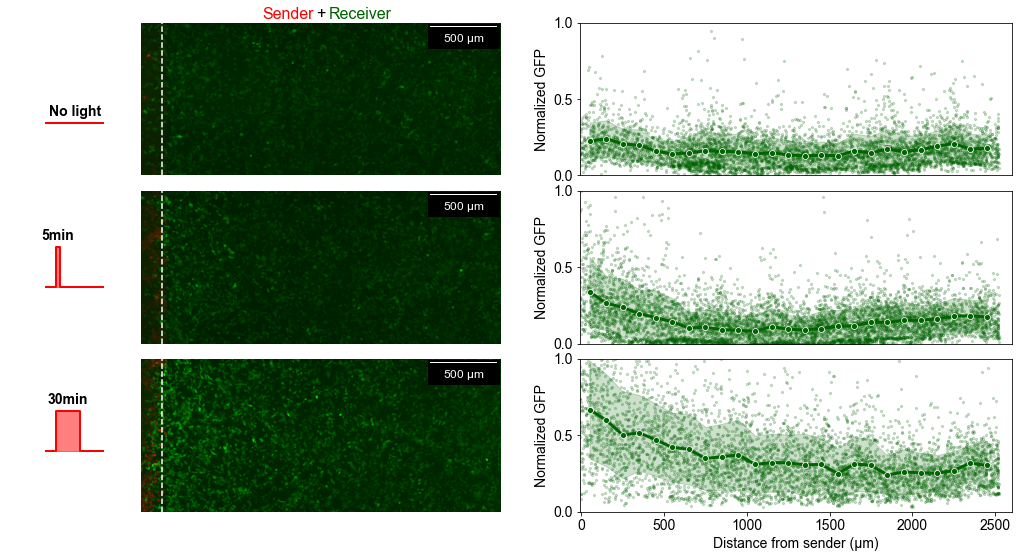

In [33]:
fig = plt.figure(figsize=(18, 9))
gs1 = GridSpec(3, 1, right=0.2, figure=fig, hspace=0.02)
gs2 = GridSpec(3, 2, left=0.2, figure=fig, hspace=0.1, wspace=0.1)
ax = [fig.add_subplot(gs1[i]) for i in range(3)]

ax[0].plot([-0.2, 1], [0, 0], c="r", lw=2)
ax[0].text(0.4, 0.1, "No light", ha="center", va="bottom", fontsize=14, family="Arial", weight="bold")
for i, duration in enumerate([5, 30]):
    ax[i+1].plot([-0.2, 0, 0, duration / 60, duration / 60, 1], [0, 0, 1, 1, 0, 0], c="r", lw=2)
    ax[i+1].fill([0, 0, duration / 60, duration / 60, 0], [0, 1, 1, 0, 0], color="r", alpha=0.5)
    ax[i+1].text(duration / 120, 1.1, "%dmin"%duration, ha="center", va="bottom", fontsize=14, family="Arial", weight="bold")
for a in ax:
    a.set_xlim([-1, 1])
    a.set_ylim([-1.5, 2.5])
    a.axis("off")

ax = np.array([[fig.add_subplot(gs2[i, j]) for j in range(2)] for i in range(3)])
im_indices = [5, 2, 3]
for i, idx in enumerate(im_indices):
    im_rgb = np.zeros((raw_im_group[0].shape[1], raw_im_group[0].shape[2], 3))
    im_rgb[:, :, 0] = (raw_im_group[idx][0, :, :] - raw_im_group[idx][0, :, :].min()) / (raw_im_group[idx][0, :, :].max() - raw_im_group[idx][0, :, :].min())
    im_rgb[:, 300:, 0] = 0
    im_rgb[:, :, 1] = raw_im_group[idx][1, :, :] / 5e3 # - all_fluorescences.min()) / (all_fluorescences.max() - all_fluorescences.min()) 
    ax[i, 0].imshow(im_rgb)
    ax[i, 0].axis("off")
    scalebar = ScaleBar(0.65, units="um", color="w", box_color='k', fixed_value=500, font_properties={"size": 12, "family": "Arial"})
    ax[i, 0].add_artist(scalebar)
    fluorescences = (props_arr_group[idx][:, 0] - min_fl) / (max_fl - min_fl)
    boundary = 250
    distances = (props_arr_group[idx][:, 1] - boundary) * 0.65
    ax[i, 1].scatter(distances, fluorescences, color="darkgreen", s=5, alpha=0.2)
    ax[i, 0].axvline(x=boundary, color="w", linestyle="--")
    
    xinterval = 100
    xbin = np.arange(0, 2500, xinterval)
    binned_distances = np.digitize(distances, xbin)
    gradient_data = np.stack([binned_distances, fluorescences], axis=1)
    gradient_df = pd.DataFrame(gradient_data, columns=["binned_distance", "intensity"])
    gradient_df.binned_distance = gradient_df.binned_distance.apply(lambda x: x * xinterval - xinterval / 2) # + xinterval / 2)
    gradient_df.drop(gradient_df[(gradient_df.binned_distance < 0)].index, inplace=True)
    sns.lineplot(x="binned_distance", y="intensity", data=gradient_df, ax=ax[i, 1], ci='sd', color="darkgreen", lw=3, marker="o")
    ax[i, 1].set_ylim([0, 1])
    ax[i, 1].set_yticks([0, 0.5, 1])
    ax[i, 1].set_ylabel("Normalized GFP")
    ax[i, 1].set_xlabel("")
    ax[i, 1].set_xlim([-10, 2600])
    ax[i, 1].set_xticks([])
    if i == 0:
        ax[i, 0].text(1700, -5, "Sender", ha="center", va="bottom", size=16, color="red")
        ax[i, 0].text(2067, -5, "+", ha="center", va="bottom", size=16, color="black")
        ax[i, 0].text(2520, -5, "Receiver", ha="center", va="bottom", size=16, color="darkgreen")
    
    if i == 2:
        ax[i, 1].set_xlabel("Distance from sender (μm)")
        ax[i, 1].set_xticks([0, 500, 1000, 1500, 2000, 2500])
save_fig("ifn_linear_main")

## Supp

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
../plotstyle.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saving figure ifn_linear_supp


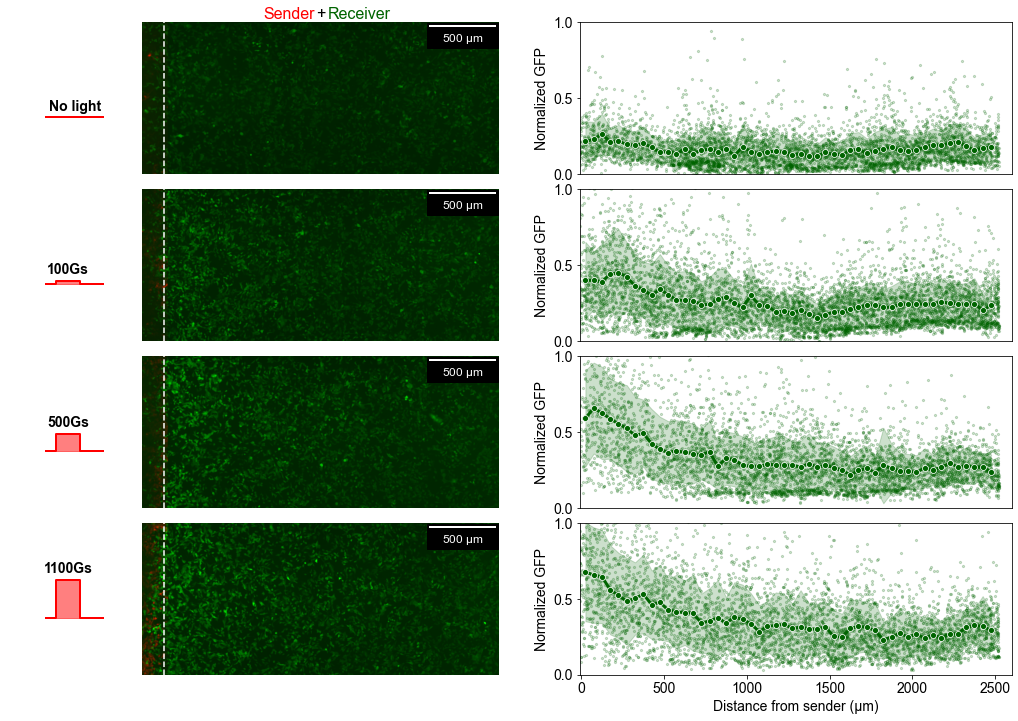

In [34]:
fig = plt.figure(figsize=(18, 12))
gs1 = GridSpec(4, 1, right=0.2, figure=fig, hspace=0.1)
gs2 = GridSpec(4, 2, left=0.2, figure=fig, hspace=0.1, wspace=0.1)
ax = [fig.add_subplot(gs1[i]) for i in range(4)]

ax[0].plot([-0.2, 1], [0, 0], c="r", lw=2)
ax[0].text(0.4, 0.1, "No light", ha="center", va="bottom", fontsize=14, family="Arial", weight="bold")
for i, intensity in enumerate([100, 500, 1100]):
    ax[i+1].plot([-0.2, 0, 0, 0.5, 0.5, 1], [0, 0, intensity / 1100, intensity / 1100, 0, 0], c="r", lw=2)
    ax[i+1].fill([0, 0, 0.5, 0.5, 0], [0, intensity / 1100, intensity / 1100, 0, 0], color="r", alpha=0.5)
    ax[i+1].text(0.25, intensity / 1100 + 0.1, "%dGs"%intensity, ha="center", va="bottom", fontsize=14, family="Arial", weight="bold")
for a in ax:
    a.set_xlim([-1, 1])
    a.set_ylim([-1.5, 2.5])
    a.axis("off")

ax = np.array([[fig.add_subplot(gs2[i, j]) for j in range(2)] for i in range(4)])
im_indices = [5, 0, 1, 3]
for i, idx in enumerate(im_indices):
    im_rgb = np.zeros((raw_im_group[0].shape[1], raw_im_group[0].shape[2], 3))
    im_rgb[:, :, 0] = (raw_im_group[idx][0, :, :] - raw_im_group[idx][0, :, :].min()) / (raw_im_group[idx][0, :, :].max() - raw_im_group[idx][0, :, :].min())
    im_rgb[:, 300:, 0] = 0
    im_rgb[:, :, 1] = raw_im_group[idx][1, :, :] / 5e3 # - all_fluorescences.min()) / (all_fluorescences.max() - all_fluorescences.min()) 
    ax[i, 0].imshow(im_rgb)
    ax[i, 0].axis("off")
    scalebar = ScaleBar(0.65, units="um", color="w", box_color='k', fixed_value=500, font_properties={"size": 12, "family": "Arial"})
    ax[i, 0].add_artist(scalebar)
    fluorescences = (props_arr_group[idx][:, 0] - min_fl) / (max_fl - min_fl)
    boundary = 250
    distances = (props_arr_group[idx][:, 1] - boundary) * 0.65
    ax[i, 1].scatter(distances, fluorescences, color="darkgreen", s=5, alpha=0.2)
    ax[i, 0].axvline(x=boundary, color="w", linestyle="--")
    
    xinterval = 50
    xbin = np.arange(0, 2500, xinterval)
    binned_distances = np.digitize(distances, xbin)
    gradient_data = np.stack([binned_distances, fluorescences], axis=1)
    gradient_df = pd.DataFrame(gradient_data, columns=["binned_distance", "intensity"])
    gradient_df.binned_distance = gradient_df.binned_distance.apply(lambda x: x * xinterval - xinterval / 2) # + xinterval / 2)
    gradient_df.drop(gradient_df[(gradient_df.binned_distance < 0)].index, inplace=True)
    sns.lineplot(x="binned_distance", y="intensity", data=gradient_df, ax=ax[i, 1], ci='sd', color="darkgreen", lw=3, marker="o")
    ax[i, 1].set_ylim([0, 1])
    ax[i, 1].set_yticks([0, 0.5, 1])
    ax[i, 1].set_ylabel("Normalized GFP")
    ax[i, 1].set_xlabel("")
    ax[i, 1].set_xlim([-10, 2600])
    ax[i, 1].set_xticks([])
    if i == 0:
        ax[i, 0].text(1700, -5, "Sender", ha="center", va="bottom", size=16, color="red")
        ax[i, 0].text(2067, -5, "+", ha="center", va="bottom", size=16, color="black")
        ax[i, 0].text(2520, -5, "Receiver", ha="center", va="bottom", size=16, color="darkgreen")
    
    if i == 3:
        ax[i, 1].set_xlabel("Distance from sender (μm)")
        ax[i, 1].set_xticks([0, 500, 1000, 1500, 2000, 2500])
save_fig("ifn_linear_supp")

$$a=2A\sqrt{k D}$$
$$a=2\times 1\times \sqrt{2.5\times 10^{-3} \times 100}=1$$